# Projet Statistiques
- [lien web vers données](https://explore.data.gouv.fr/fr/datasets/586dae65a3a7290df6f4be90/?Code%20de%20la%20discipline__exact=disc06&Ann%C3%A9e__exact=2020#/resources/c7c9642b-9fa1-40a0-83d5-1615c15b4178)

- Installation de requirements.txt

In [68]:
#%pip install -r requirements.txt

- Importation des librairies

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy
import warnings
import random
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from scipy.stats import (normaltest, shapiro, anderson, ttest_ind)
warnings.filterwarnings(action = "ignore")
random.seed(123)
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)

## Partie 1: Exploration et Pre-processing des données 

### Chargement des données

In [148]:
# fonction pour avoi des informations sur les colonnes et les valeurs manquantes
def info(data):
    shape = data.shape

    Information = pd.DataFrame({
        'Variables': data.columns,
        'Type': data.dtypes,
        'Unique_values': data.nunique(),
        'NA_counts': data.isna().sum(),
        'NA_percent%':data.isna().mean().round(4)*100,
        }).reset_index(drop=True)
    
    print(f"Taille des données: {shape[0]:.2f} lignes\nNombre de variables: {shape[1]}")
    return Information

In [71]:
data = pd.read_csv("fr-esr-insertion_professionnelle-master_donnees_nationales.csv",sep=';')
info(data)

Taille des données: 3267.00 lignes
Nombre de variables: 77


Variables     Type  Unique_values  \
0                                               Année    int64             10   
1                                             Diplôme   object              2   
2                                           situation   object              2   
3                                               Genre   object              3   
4                                         Disciplines   object             69   
5                                     Code du domaine   object              6   
6                                             Domaine   object              6   
7                               Code de la discipline   object             21   
8                                          Discipline   object             22   
9                       Code du secteur disciplinaire   object             68   
10                              Secteur disciplinaire   object             68   
11                                 Nombre de réponses  float64            809   
12                                   Taux d’insertion   object             43   
13                                      Taux d'emploi   object             34   
14                    Taux d'emploi salarié en France   object             45   
15  Part des emplois de niveau cadre ou profession...   object             56   
16                   Part des emplois de niveau cadre   object             87   
17   % emplois extérieurs à la région de l’université   object             72   
18                           Part des emplois stables   object             83   
19                     Part des emplois à temps plein   object             46   
20  Salaire net mensuel médian des emplois à temps...   object            131   
21                         Salaire brut annuel estimé   object            189   
22  Premier quartile des salaires nets mensuels de...   object            106   
23  Dernier quartile des salaires nets mensuels de...   object            150   
24     Part des diplômés boursiers dans la discipline   object             46   
25                                    Part des femmes   object             88   
26                           Taux de chômage national  float64              9   
27                Salaire net mensuel médian national    int64              8   
28                 Code du secteur disciplinaire SISE   object             53   
29          Salaire net mensuel national 1er quartile  float64              7   
30         Salaire net mensuel national 3ème quartile  float64              7   
31                                           cle_DISC   object            134   
32     Prof. libérale, indépendant, chef d’entreprise   object             26   
33                                      Fonctionnaire   object             34   
34                                                CDI   object             86   
35                  CDI de chantier ou CDI de mission   object              9   
36                     Contrat spécifique au doctorat  float64              1   
37                                                CDD   object             62   
38                                          Vacataire   object             10   
39                                        Intérimaire   object             13   
40                          Intermittent du spectacle   object             17   
41                    Contrat de professionnalisation   object              5   
42         Emplois aidés (Contrat Initiative Emploi…)   object              8   
43                          Volontariat international   object             11   
44                                          Vous-même   object             82   
45  La fonction publique (d'etat, territoriale ou ...   object             61   
46                              Une entreprise privée   object             87   
47                            Une entreprise publique   object             41   
48                                    Une association   object             

- Suppression des lignes de cumuls des réponses  
suivant la colonne "Code du secteur disciplinaire"

In [72]:
# Suppression des cumuls des codes du secteur disciplinaire
# du type discXX (exemple: disc01) à l'exception de disc18
# qui correspond au MasterENS et on garde les discXX_YY (exemple: disc05_08)
pattern = r"disc(0[0-9]|1[0-7])$"
data = data[~data['Code du secteur disciplinaire'].str.contains(pattern,regex=True)]

### Sélection des variables pour l'analyse

In [73]:
# variables retenues pour l'analyse
variables = ['Année', 'Diplôme', 'situation', 'Genre', 'Discipline',  
             'Code de la discipline', 'Nombre de réponses', 'Taux d’insertion',
             'Part des emplois de niveau cadre ou profession intermédiaire',
             'Part des emplois de niveau cadre',
             "% emplois extérieurs à la région de l’université",
             'Part des emplois stables', 'Part des emplois à temps plein',
             'Salaire net mensuel médian des emplois à temps plein',
             'Salaire brut annuel estimé',
             'Premier quartile des salaires nets mensuels des emplois à temps plein',
             'Dernier quartile des salaires nets mensuels des emplois à temps plein',
             'Part des diplômés boursiers dans la discipline']

In [74]:
datafilter = data[variables]
datafilter.head(5)

Année     Diplôme                 situation   Genre  \
0   2014  MASTER LMD  30 mois après le diplôme  femmes   
1   2016  MASTER LMD  18 mois après le diplôme  hommes   
2   2012  MASTER LMD  30 mois après le diplôme  hommes   
3   2012  MASTER LMD  30 mois après le diplôme  femmes   
4   2012  MASTER LMD  18 mois après le diplôme  hommes   

                                          Discipline Code de la discipline  \
0  Autres formations juridiques, économiques et d...                disc05   
1  Autres formations juridiques, économiques et d...                disc05   
2  Autres formations juridiques, économiques et d...                disc05   
3  Autres formations juridiques, économiques et d...                disc05   
4  Autres formations juridiques, économiques et d...                disc05   

   Nombre de réponses Taux d’insertion  \
0                39.0               87   
1                32.0               84   
2                 NaN               ns   
3                 NaN               ns   
4                 NaN               ns   

  Part des emplois de niveau cadre ou profession intermédiaire  \
0                                                 66             
1                                                 ns             
2                                                 ns             
3                                                 ns             
4                                                 ns             

  Part des emplois de niveau cadre  \
0                               44   
1                               ns   
2                               ns   
3                               ns   
4                              NaN   

  % emplois extérieurs à la région de l’université Part des emplois stables  \
0                                               50                       59   
1                                               ns                       ns   
2                                               ns                       ns   
3                                               ns                       ns   
4                                               ns                       ns   

  Part des emplois à temps plein  \
0                            100   
1                             ns   
2                             ns   
3                             ns   
4                             ns   

  Salaire net mensuel médian des emplois à temps plein  \
0                                                 ns     
1                                                 ns     
2                                                 ns     
3                                                 ns     
4                                                 ns     

  Salaire brut annuel estimé  \
0                         ns   
1                         ns   
2                         ns   
3                         ns   
4                         ns   

  Premier quartile des salaires nets mensuels des emplois à temps plein  \
0                                                 ns                      
1                                                 ns                      
2                                                 ns                      
3                                                 ns                      
4                                                 ns                      

  Dernier quartile des salaires nets mensuels des emplois à temps plein  \
0                                                 ns                      
1                                                 ns                      
2                                                 ns                      
3                                                 ns                      
4                                                 ns                      

  Part des diplômés boursiers dans la discipline  
0                                             48  
1                                             35  
2                

In [75]:
# Suppression des lignes labellisées "femmes et hommes" 
datafilter = datafilter[(datafilter["Genre"].isin(["femmes", "hommes"]))]

# Suppression des lignes avec (ns,na, vide) suivant la colonne taux d'insertion
datafilter = datafilter[~(datafilter["Taux d’insertion"].isin(["ns", "nd", np.nan]))]
info(datafilter)

Taille des données: 1278.00 lignes
Nombre de variables: 18


Variables     Type  Unique_values  \
0                                               Année    int64              9   
1                                             Diplôme   object              2   
2                                           situation   object              2   
3                                               Genre   object              2   
4                                          Discipline   object             10   
5                               Code de la discipline   object             10   
6                                  Nombre de réponses  float64            323   
7                                    Taux d’insertion   object             41   
8   Part des emplois de niveau cadre ou profession...   object             54   
9                    Part des emplois de niveau cadre   object             84   
10   % emplois extérieurs à la région de l’université   object             67   
11                           Part des emplois stables   object             79   
12                     Part des emplois à temps plein   object             39   
13  Salaire net mensuel médian des emplois à temps...   object            126   
14                         Salaire brut annuel estimé   object            169   
15  Premier quartile des salaires nets mensuels de...   object            100   
16  Dernier quartile des salaires nets mensuels de...   object            133   
17     Part des diplômés boursiers dans la discipline   object             44   

    NA_counts  NA_percent%  
0           0         0.00  
1           0         0.00  
2           0         0.00  
3           0         0.00  
4           0         0.00  
5           0         0.00  
6         151        11.82  
7           0         0.00  
8           0         0.00  
9          74         5.79  
10          0         0.00  
11          0         0.00  
12          0         0.00  
13          0         0.00  
14          0         0.00  
15          0         0.00  
16          0         0.00  
17        147        11.50

In [76]:
# fonction pour mettre les variables dans le bon type (category, float, etc..)

def conversion(var):

    # remplacer les 'ns' par NaN
    var.replace({'ns':np.nan,'nd':np.nan}, inplace = True) 

    # conversion des variables type = <objet>
    if (var.dtype == 'object') and (var.name != 'Année'):

        try:

            # conversion en float
            if var.nunique() > 22:
                return var.astype('float')

            # conversion en catégorie 
            else:
                return var.astype('category')
        
        except ValueError:
            
            return var
    
    else:
        return var 


In [150]:
# Application sur nos données
datafilter = datafilter.apply(conversion)
info(datafilter)

Taille des données: 1278.00 lignes
Nombre de variables: 18


Variables      Type  \
0                                               Année     int64   
1                                             Diplôme  category   
2                                           situation  category   
3                                               Genre  category   
4                                          Discipline  category   
5                               Code de la discipline  category   
6                                  Nombre de réponses   float64   
7                                    Taux d’insertion   float64   
8   Part des emplois de niveau cadre ou profession...   float64   
9                    Part des emplois de niveau cadre   float64   
10   % emplois extérieurs à la région de l’université   float64   
11                           Part des emplois stables   float64   
12                     Part des emplois à temps plein   float64   
13  Salaire net mensuel médian des emplois à temps...   float64   
14                         Salaire brut annuel estimé   float64   
15  Premier quartile des salaires nets mensuels de...   float64   
16  Dernier quartile des salaires nets mensuels de...   float64   
17     Part des diplômés boursiers dans la discipline   float64   

    Unique_values  NA_counts  NA_percent%  
0               9          0         0.00  
1               2          0         0.00  
2               2          0         0.00  
3               2          0         0.00  
4              10          0         0.00  
5              10          0         0.00  
6             323        151        11.82  
7              41          0         0.00  
8              53         80         6.26  
9              83        147        11.50  
10             66         64         5.01  
11             78         73         5.71  
12             38         77         6.03  
13            125        150        11.74  
14            168        140        10.95  
15             99        381        29.81  
16            132        381        29.81  
17             43        154        12.05

### Imputation des valeurs manquantes 

In [80]:
# fonction pour imputer les valeurs manquantes
# sur l 'ensemble du dataframe avec KNNImputer

def imputing(dataframe:pd.DataFrame):
    
    # extraction noms des colonnes
    copie = dataframe.copy(deep=True)
    colonnes = copie.columns.tolist()

    # création de KNNImputer
    imputer = KNNImputer(n_neighbors=5)

    # création de Ordinalencoder pour les variables
    # catégorielles
    encoder = OrdinalEncoder()

    # Sélection des variables catégorielles et encodage
    catvars = copie.select_dtypes(include = ['category']).columns
    copie[catvars] = encoder.fit_transform(copie[catvars])
    
    # Imputation des valeurs manquantes 
    matrix = imputer.fit_transform(copie)

    imputedata = pd.DataFrame(matrix, columns = colonnes)
    
    # Retour aux valeurs d'origine des variables encodées
    imputedata[catvars] = encoder.inverse_transform(imputedata[catvars])
    imputedata[catvars] = imputedata[catvars].astype('category')
    # Données transformées
    return imputedata


In [81]:
imputedata = imputing(datafilter)
imputedata['Année'] = imputedata['Année'].astype('int')
info(imputedata)

Taille des données: 1278.00 lignes
Nombre de variables: 18


Variables      Type  \
0                                               Année     int32   
1                                             Diplôme  category   
2                                           situation  category   
3                                               Genre  category   
4                                          Discipline  category   
5                               Code de la discipline  category   
6                                  Nombre de réponses   float64   
7                                    Taux d’insertion   float64   
8   Part des emplois de niveau cadre ou profession...   float64   
9                    Part des emplois de niveau cadre   float64   
10   % emplois extérieurs à la région de l’université   float64   
11                           Part des emplois stables   float64   
12                     Part des emplois à temps plein   float64   
13  Salaire net mensuel médian des emplois à temps...   float64   
14                         Salaire brut annuel estimé   float64   
15  Premier quartile des salaires nets mensuels de...   float64   
16  Dernier quartile des salaires nets mensuels de...   float64   
17     Part des diplômés boursiers dans la discipline   float64   

    Unique_values  NA_counts  NA_percent%  
0               9          0          0.0  
1               2          0          0.0  
2               2          0          0.0  
3               2          0          0.0  
4              10          0          0.0  
5              10          0          0.0  
6             357          0          0.0  
7              41          0          0.0  
8              95          0          0.0  
9             162          0          0.0  
10            104          0          0.0  
11            121          0          0.0  
12             85          0          0.0  
13            219          0          0.0  
14            263          0          0.0  
15            268          0          0.0  
16            314          0          0.0  
17             91          0          0.0

In [82]:
imputedata.head(10)

Année     Diplôme                 situation   Genre  \
0   2014  MASTER LMD  30 mois après le diplôme  femmes   
1   2016  MASTER LMD  18 mois après le diplôme  hommes   
2   2016  MASTER LMD  30 mois après le diplôme  femmes   
3   2017  MASTER LMD  30 mois après le diplôme  femmes   
4   2017  MASTER LMD  18 mois après le diplôme  femmes   
5   2013  MASTER LMD  30 mois après le diplôme  hommes   
6   2018  MASTER LMD  18 mois après le diplôme  femmes   
7   2019  MASTER LMD  18 mois après le diplôme  hommes   
8   2020  MASTER LMD  18 mois après le diplôme  femmes   
9   2017  MASTER LMD  30 mois après le diplôme  femmes   

                                          Discipline Code de la discipline  \
0  Autres formations juridiques, économiques et d...                disc05   
1  Autres formations juridiques, économiques et d...                disc05   
2  Autres formations juridiques, économiques et d...                disc05   
3  Autres formations juridiques, économiques et d...                disc05   
4  Autres formations juridiques, économiques et d...                disc05   
5  Autres formations juridiques, économiques et d...                disc05   
6  Autres formations juridiques, économiques et d...                disc05   
7  Autres formations juridiques, économiques et d...                disc05   
8  Autres formations juridiques, économiques et d...                disc05   
9  Autres formations juridiques, économiques et d...                disc05   

   Nombre de réponses  Taux d’insertion  \
0                39.0              87.0   
1                32.0              84.0   
2                97.0              90.0   
3               101.0              90.0   
4               171.0              96.0   
5               176.0              92.0   
6               133.0              94.0   
7                45.0              81.0   
8                55.0              88.0   
9               171.0              97.0   

   Part des emplois de niveau cadre ou profession intermédiaire  \
0                                               66.0              
1                                               76.0              
2                                               74.0              
3                                               83.0              
4                                               84.0              
5                                               89.0              
6                                               91.0              
7                                               96.0              
8                                               75.0              
9                                               88.0              

   Part des emplois de niveau cadre  \
0                              44.0   
1                              53.6   
2                              41.0   
3                              57.0   
4                              52.0   
5                              66.0   
6                              51.0   
7                              62.0   
8                              46.0   
9                              63.0   

   % emplois extérieurs à la région de l’université  Part des emplois stables  \
0                                              50.0                      59.0   
1                                              49.4                      63.2   
2                                               6.0                      75.0   
3                                              12.0                      75.0   
4                                              41.0                      74.0   
5                                              23.0                      88.0   
6                                              41.0                      76.0   
7                                              52.0                      67.0   
8                                              51.0                      58.0   
9                                              41.0  

## Partie 2 : Statistiques Descriptives et Visuelles 

### Visualisation des données

- Pairplot (distibution deux à deux )

In [84]:
liste1 = ["Taux d’insertion",'Genre',
          'Part des emplois de niveau cadre ou profession intermédiaire',
          'Part des emplois de niveau cadre',
          "% emplois extérieurs à la région de l’université"]

liste2 = ["Taux d’insertion",'Genre',
          'Part des emplois stables', 'Part des emplois à temps plein',
          'Salaire net mensuel médian des emplois à temps plein',
          'Salaire brut annuel estimé']

liste3 = ["Taux d’insertion",'Genre',
          'Premier quartile des salaires nets mensuels des emplois à temps plein',
          'Dernier quartile des salaires nets mensuels des emplois à temps plein',
          'Part des diplômés boursiers dans la discipline']

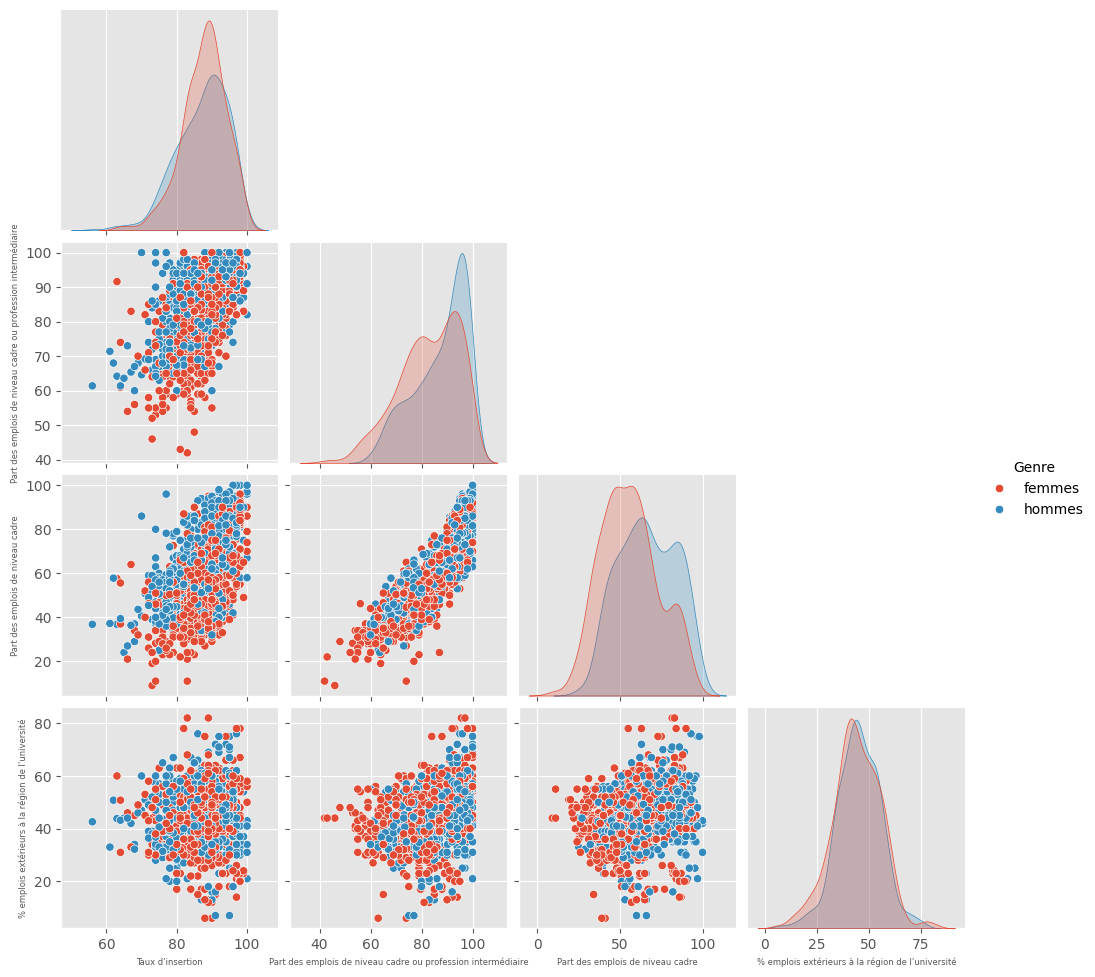

In [154]:
# Exemple de pairplot avec réduction de la taille de police des noms de variables
pairplot = sns.pairplot(
    data=imputedata[liste1],
    hue='Genre',
    corner=True
)

# Réduction de la taille de la police des noms des variables
for ax in pairplot.fig.axes:
    ax.xaxis.label.set_size(6)# Taille de police des noms sur l'axe X
    ax.yaxis.label.set_size(6)# Taille de police des noms sur l'axe Y

# Afficher le graphique
plt.show()


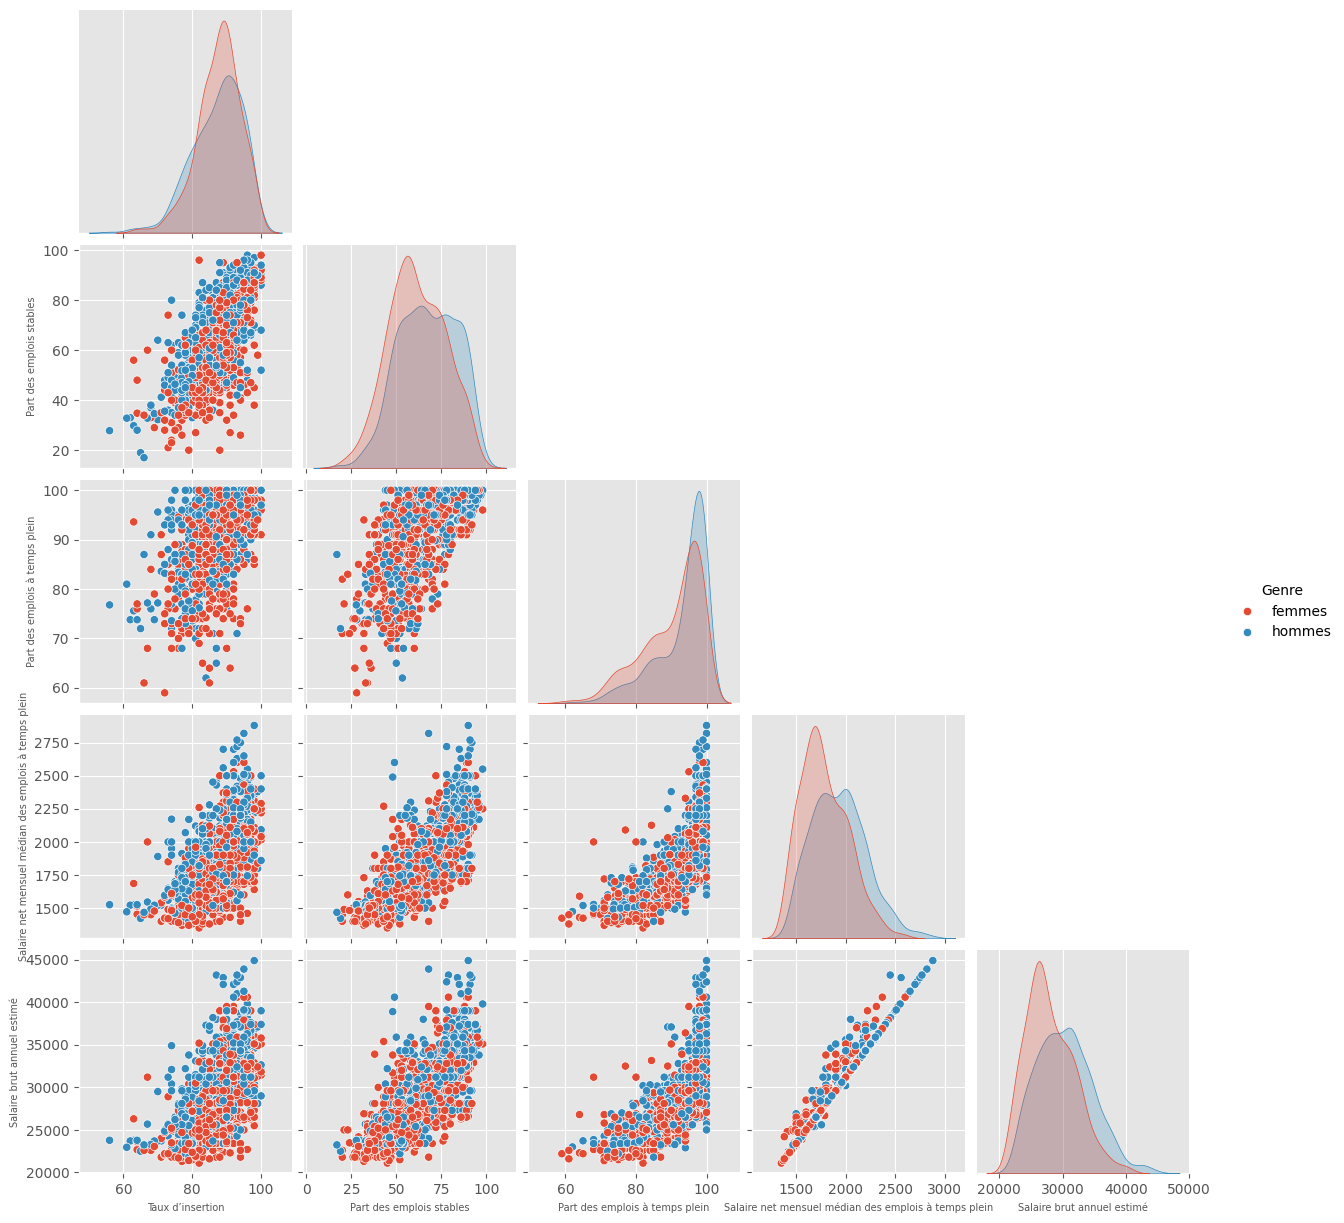

In [145]:
# Exemple de pairplot avec réduction de la taille de police des noms de variables
pairplot = sns.pairplot(
    data=imputedata[liste2],
    hue='Genre',
    corner=True
)

# Réduction de la taille de la police des noms des variables
for ax in pairplot.fig.axes:
    ax.xaxis.label.set_size(7)# Taille de police des noms sur l'axe X
    ax.yaxis.label.set_size(7)# Taille de police des noms sur l'axe Y

# Afficher le graphique
plt.show()


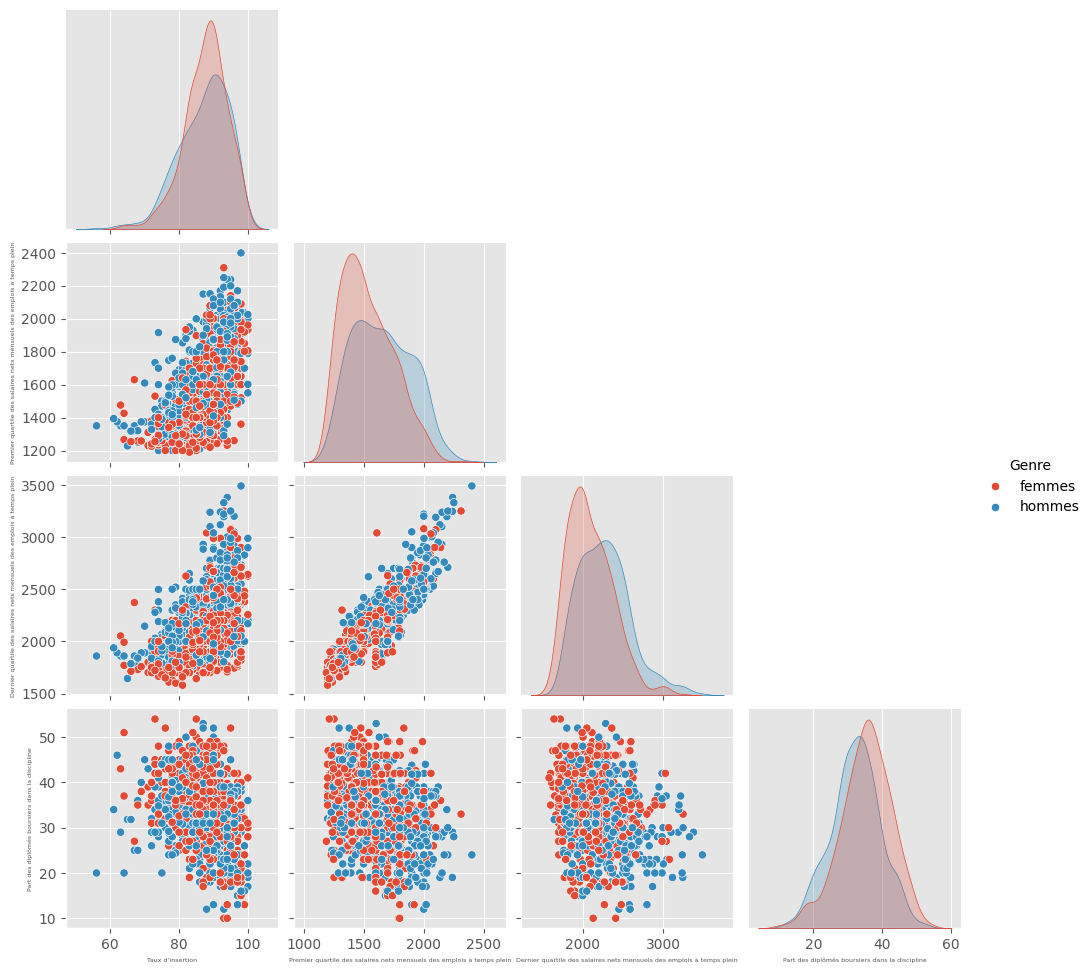

In [160]:
# Exemple de pairplot avec réduction de la taille de police des noms de variables
pairplot = sns.pairplot(
    data=imputedata[liste3],
    hue='Genre',
    corner=True
)

# Réduction de la taille de la police des noms des variables
for ax in pairplot.fig.axes:
    ax.xaxis.label.set_size(4.5)# Taille de police des noms sur l'axe X
    ax.yaxis.label.set_size(4.5)# Taille de police des noms sur l'axe Y

# Afficher le graphique
plt.show()


- Heatmap des corrélations entre les variables continues

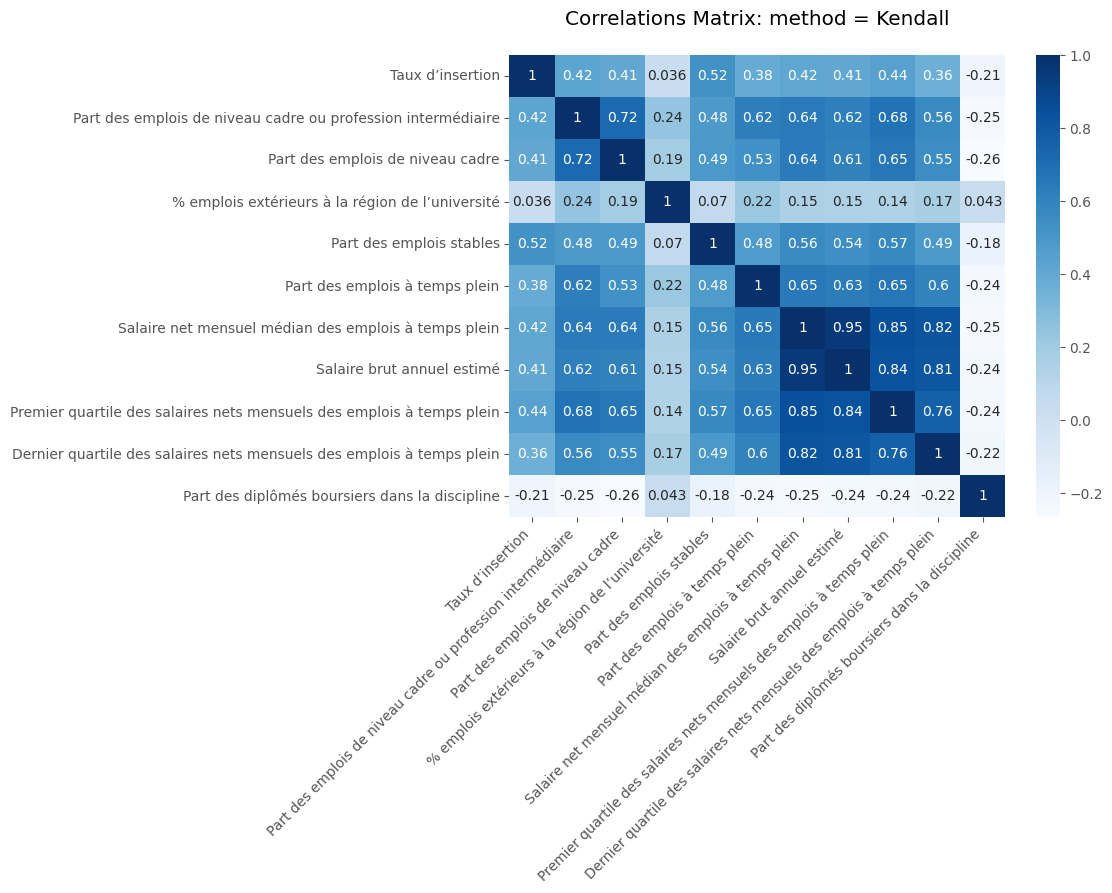

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(imputedata.loc[:, "Taux d’insertion":].corr(method='kendall'),
            cmap='Blues', annot=True)
plt.title('Correlations Matrix: method = Kendall\n')
plt.xticks(rotation=45, ha='right')
plt.show()

- Distribution du Taux d'insertion par Master et Genre

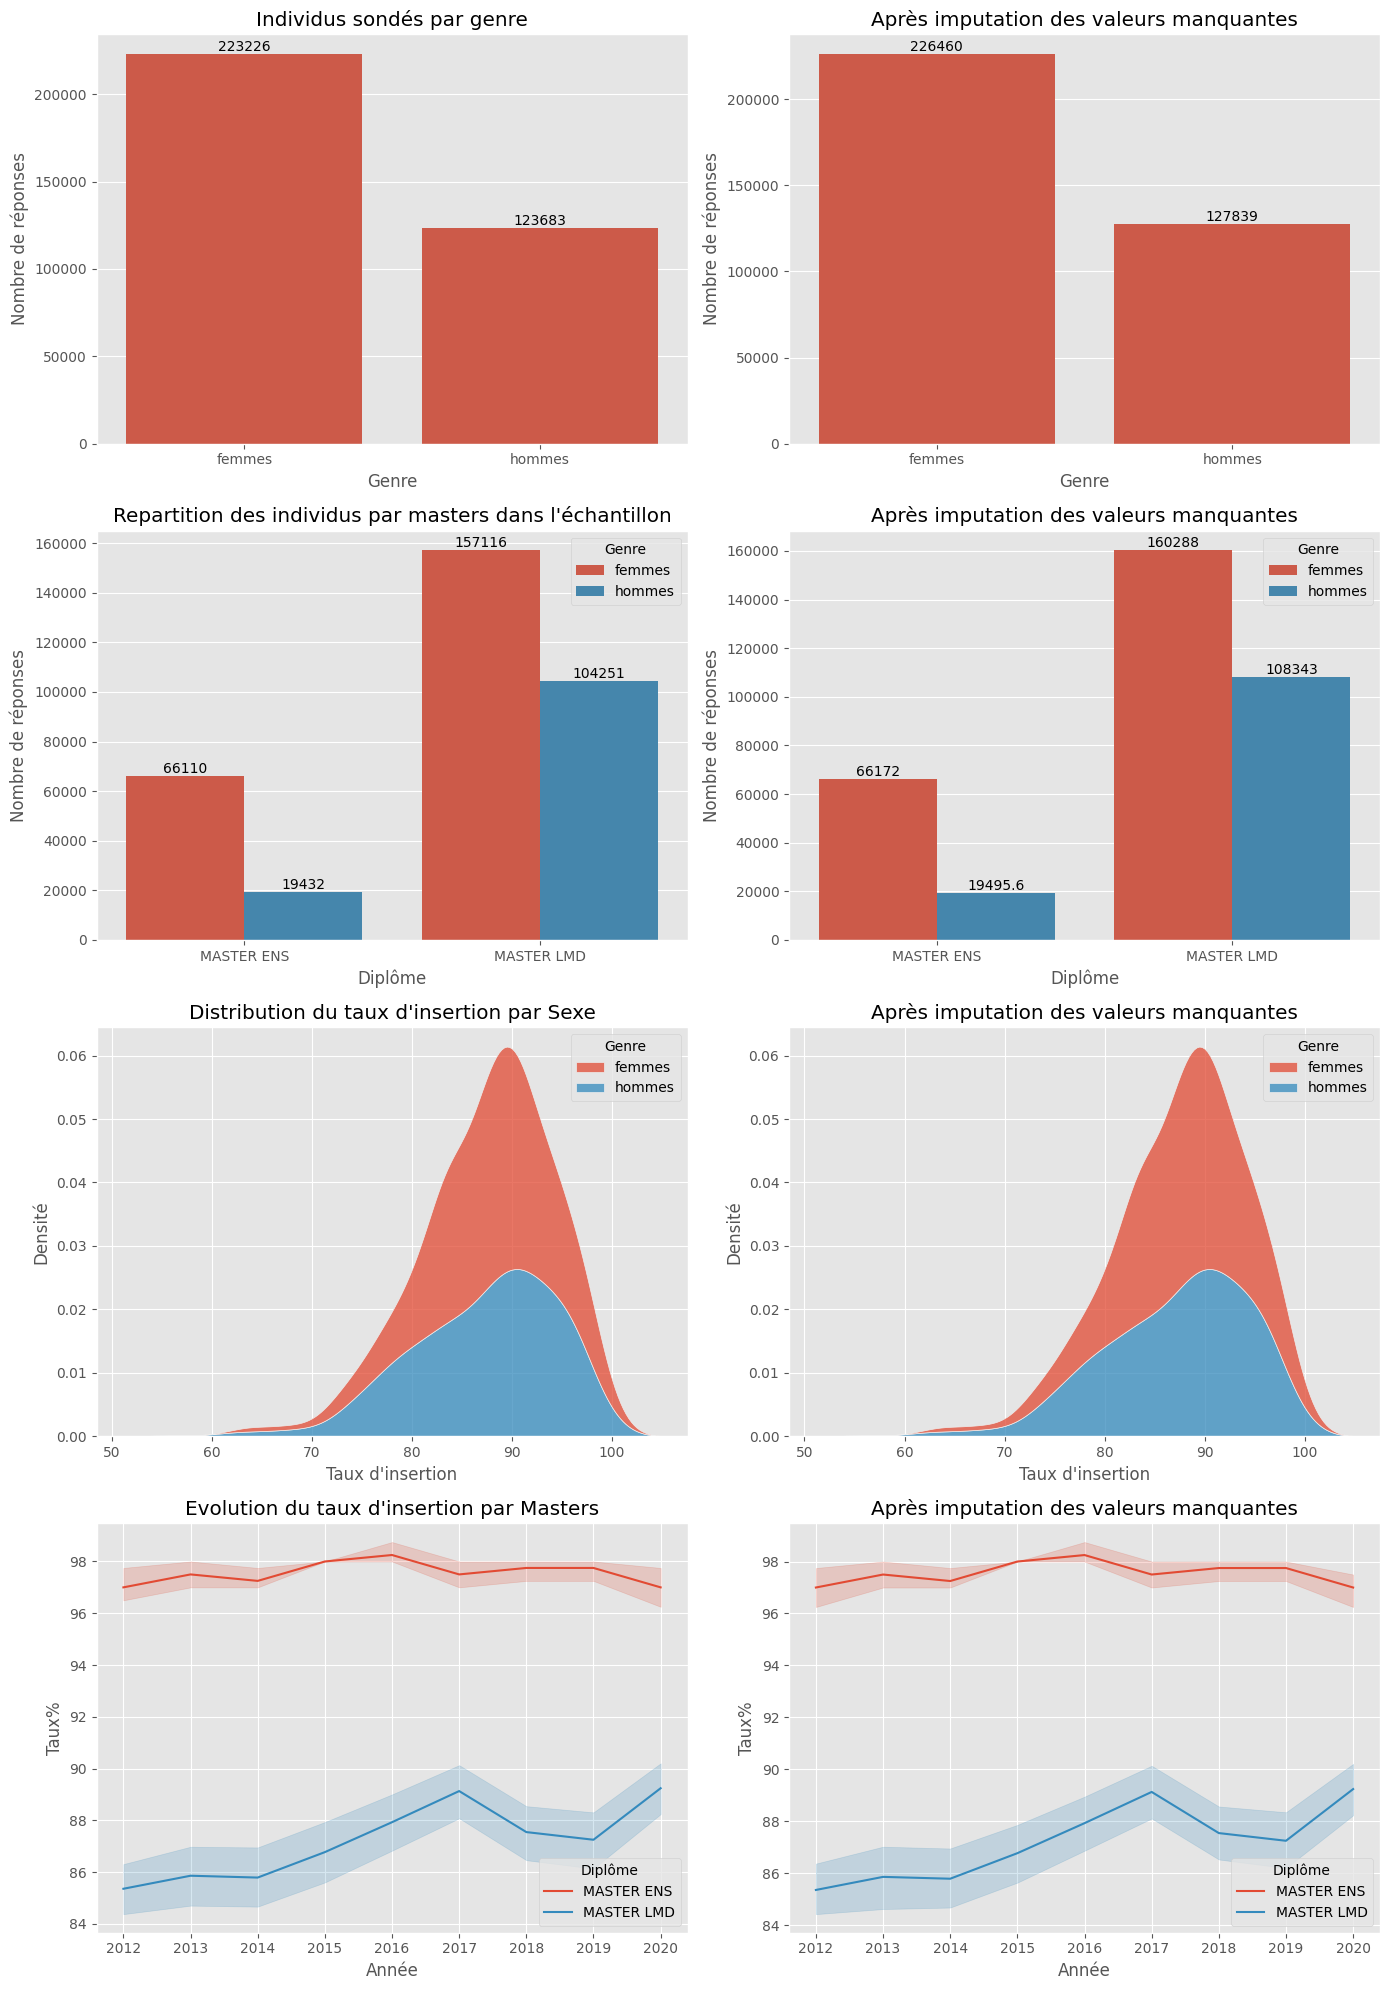

In [151]:
plt.style.use('ggplot')
fig, ax = plt.subplots(4, 2, figsize=(14, 20))

sns.barplot(datafilter, x="Genre", y="Nombre de réponses", estimator="sum",
                     ax = ax[0,0], errorbar=None)
ax[0,0].bar_label(ax[0,0].containers[0], fontsize=10)
ax[0,0].set_title("Individus sondés par genre")

sns.barplot(imputedata, x="Genre", y="Nombre de réponses", estimator="sum",
                     ax = ax[0,1], errorbar=None)
ax[0,1].bar_label(ax[0,1].containers[0], fontsize=10)
ax[0,1].set_title("Après imputation des valeurs manquantes")


sns.barplot(datafilter, x="Diplôme", y="Nombre de réponses", hue="Genre",
                        estimator="sum", errorbar=None, ax = ax[1,0])

ax[1,0].bar_label(ax[1,0].containers[0], fontsize=10)
ax[1,0].bar_label(ax[1,0].containers[1], fontsize=10)
ax[1,0].set_title("Repartition des individus par masters dans l'échantillon")

sns.barplot(imputedata, x="Diplôme", y="Nombre de réponses", hue="Genre",
                        estimator="sum", errorbar=None, ax = ax[1,1])

ax[1,1].bar_label(ax[1,1].containers[0], fontsize=10)
ax[1,1].bar_label(ax[1,1].containers[1], fontsize=10)
ax[1,1].set_title("Après imputation des valeurs manquantes")

sns.kdeplot(data=datafilter, x="Taux d’insertion",
            hue="Genre", multiple="stack", ax=ax[2,0])
ax[2,0].set_title("Distribution du taux d'insertion par Sexe")
ax[2,0].set_xlabel("Taux d'insertion")
ax[2,0].set_ylabel("Densité")

sns.kdeplot(data=imputedata, x="Taux d’insertion",
            hue="Genre", multiple="stack", ax=ax[2,1])
ax[2,1].set_title("Après imputation des valeurs manquantes")
ax[2,1].set_xlabel("Taux d'insertion")
ax[2,1].set_ylabel("Densité")

sns.lineplot(data=datafilter, x="Année", y="Taux d’insertion",
             hue="Diplôme", ax=ax[3,0])
ax[3,0].set_title("Evolution du taux d'insertion par Masters")
ax[3,0].set_xlabel("Année")
ax[3,0].set_ylabel("Taux%")

sns.lineplot(data=imputedata, x="Année", y="Taux d’insertion",
             hue="Diplôme", ax=ax[3,1])
ax[3,1].set_title("Après imputation des valeurs manquantes")
ax[3,1].set_xlabel("Année")
ax[3,1].set_ylabel("Taux%")

plt.tight_layout()
plt.show()


### Tests statistiques sur les données

#### Hypothèses de normalité
- H0: La distribution suit une loi normale
- H1: la distribution ne suit pas une loi normale  
Règles de décision:
- P-value < 0.05 (5%), rejet de H0 sinon non 

- Test de normalité sur les données (taux d'insertion)

In [92]:
print(normaltest(imputedata['Taux d’insertion']),'\n\n',
                 shapiro(imputedata['Taux d’insertion']),'\n\n',
                 anderson(imputedata['Taux d’insertion'], dist='norm'))

NormaltestResult(statistic=110.53663080424309, pvalue=9.937464649882501e-25) 

 ShapiroResult(statistic=0.9666887986749284, pvalue=1.490153166194514e-16) 

 AndersonResult(statistic=8.427534422762164, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=87.46870109546165, scale=6.7750664561012)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


- Les Resultats des tests de normalité  
les resultats des 3 tests de normalité sur le taux d'insertion  
--Shapiro_Wilk  
--Agostino_Pearson (skewness & Kurtosis)  
--Anderson_Darling (comparaison à une distribution théorique)  
montrent que les données de taux d'insertion ne suivent pas une loi normale.

## Partie 3: Régression
Explication de la variable taux d'insertion en fonction de:
 - 'Genre'
 - 'Discipline'
 - 'situation' 
 - 'Part des emplois de niveau cadre ou profession intermédiaire'
 - 'Part des emplois stables'

### Régression OLS

In [100]:
#'Discipline',
features = ['situation', 'Genre', 'Discipline',
            'Part des emplois de niveau cadre ou profession intermédiaire',
            'Part des emplois stables']

# Variable à expliquer
var_endogene = imputedata['Taux d’insertion']

# variables explicatives
var_exogenes = imputedata[features]
var_exogenes['situation'] = var_exogenes['situation'].str[:2]

# Encodage en dummies de Genre
var_exogenes = pd.get_dummies(var_exogenes,
                              columns=['Genre', 'situation','Discipline'],
                                    drop_first=True).astype(int)

          
# Ajout d'une constante (1) à la matrice des variables explicatives
var_exogenes_cst = sm.add_constant(var_exogenes, prepend=False)

# Suppression des catégories non significatives dans le modèle
var_exogenes_cst = var_exogenes_cst.drop(columns = ['Discipline_Autres sciences, technologies et santé',
                                                     'Discipline_Droit',
                                                     'Discipline_Histoire-géographie',
                                                     'Discipline_Lettres, langues, arts'],
                                         axis = 1)
# Définition et estimation du modèle
modele = sm.OLS(var_endogene, var_exogenes_cst)

# Résultats du modèle
resultats = modele.fit()

# Affichage des résultats
print(resultats.summary2())

                                       Results: Ordinary least squares
Model:                             OLS                            Adj. R-squared:                   0.595    
Dependent Variable:                Taux d’insertion               AIC:                              7372.2128
Date:                              2025-01-12 16:27               BIC:                              7423.7433
No. Observations:                  1278                           Log-Likelihood:                   -3676.1  
Df Model:                          9                              F-statistic:                      209.4    
Df Residuals:                      1268                           Prob (F-statistic):               1.64e-243
R-squared:                         0.598                          Scale:                            18.595   
-------------------------------------------------------------------------------------------------------------
                                                 

### Analyse post_régression et des résidus

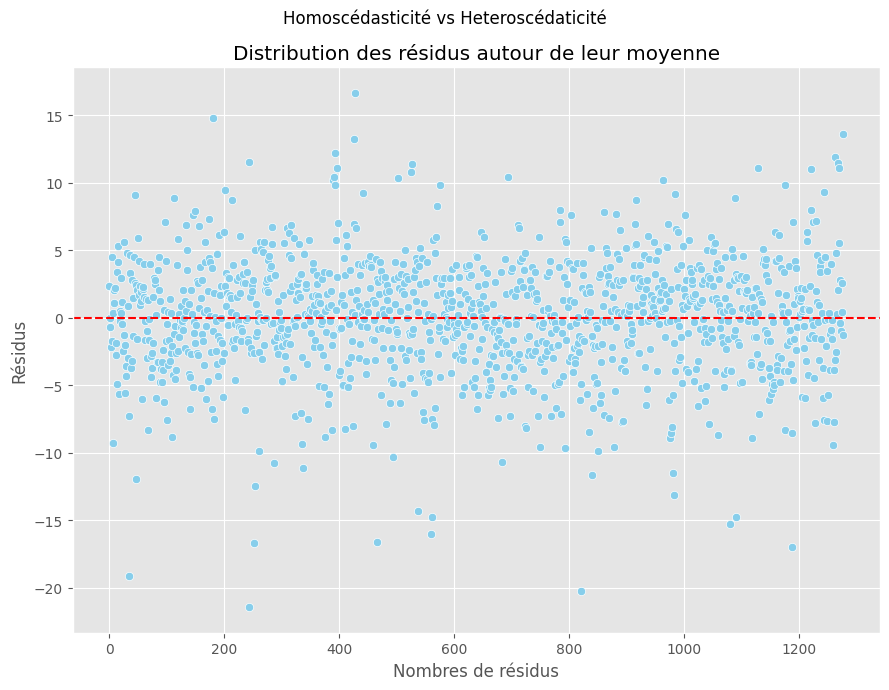

In [118]:
residus = resultats.resid

plt.figure(figsize=(9,7))
sns.scatterplot(data=residus, color = 'skyblue')
plt.axhline(y = np.mean(residus), color='red', linestyle='--')
plt.title("Distribution des résidus autour de leur moyenne")
plt.suptitle("Homoscédasticité vs Heteroscédaticité")
plt.ylabel("Résidus")
plt.xlabel("Nombres de résidus")
plt.tight_layout()
plt.show()

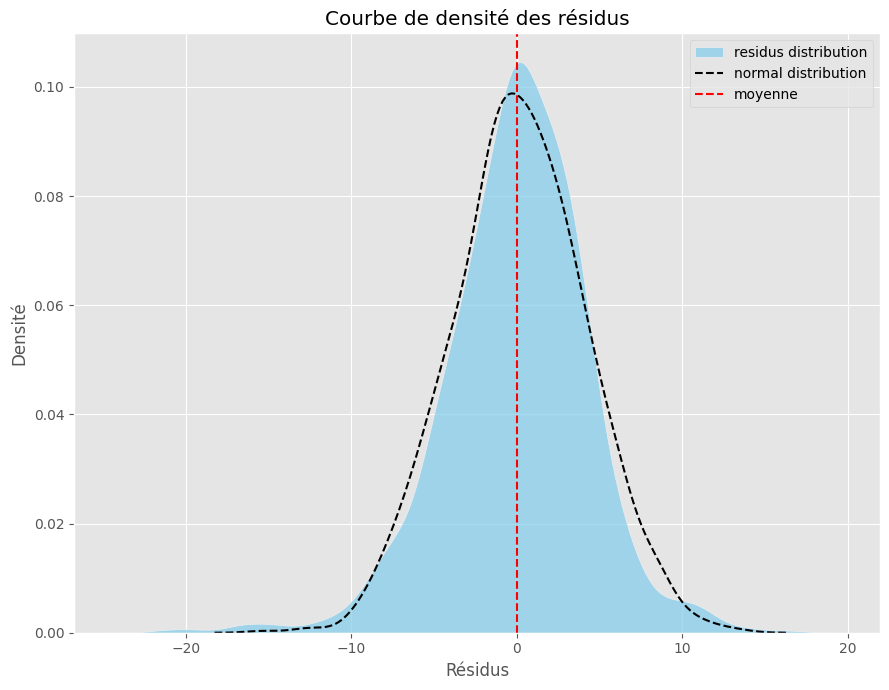

In [141]:
# Générer une distribution normale théorique
normal = np.random.normal(loc=0, scale=4, size=1278)

plt.figure(figsize=(9,7))
sns.kdeplot(data=residus, color = 'skyblue',multiple="stack", label = 'residus distribution')
sns.kdeplot(data=normal, color = 'black', linestyle='--', label="normal distribution")
plt.axvline(x = np.mean(residus), color='red', linestyle='--', label = 'moyenne')
plt.title("Courbe de densité des résidus")
plt.ylabel("Densité")
plt.xlabel("Résidus")
plt.legend()
plt.tight_layout()
plt.show()

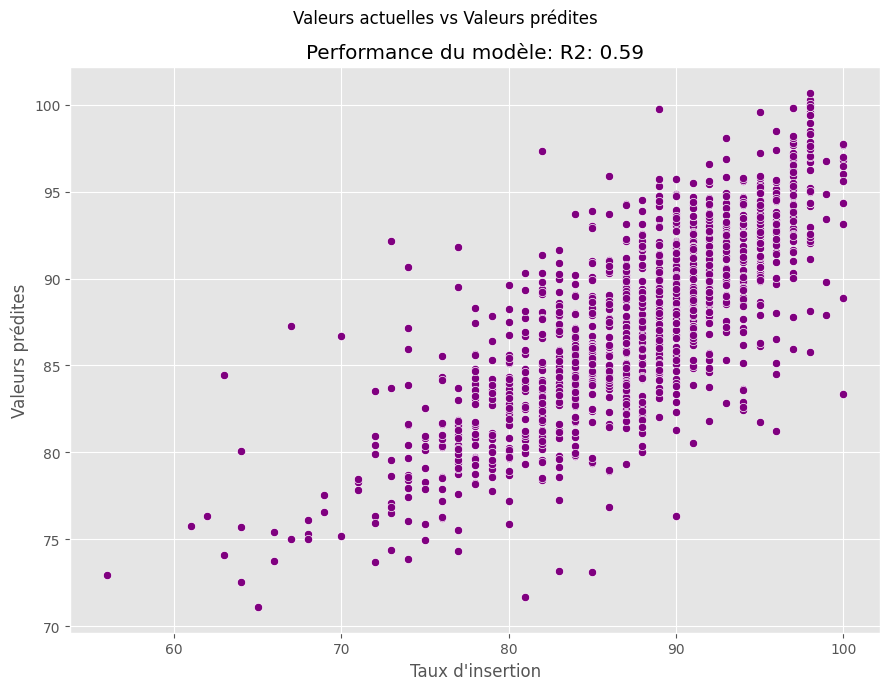

In [123]:

predicted_var_endogene = resultats.predict(var_exogenes_cst)
plt.figure(figsize=(9,7))
sns.scatterplot(x = var_endogene, y = predicted_var_endogene, color = 'purple')
# plt.axhline(y = np.mean(residus), color='red', linestyle='--')
plt.title(f"Performance du modèle: R2: {resultats.rsquared_adj:.2f}")
plt.suptitle("Valeurs actuelles vs Valeurs prédites")
plt.xlabel("Taux d'insertion")
plt.ylabel("Valeurs prédites")
plt.tight_layout()
plt.show()

### Alternative avec un modèle GLS (Moindres Carrés Généralisées)

In [142]:
gls_model = sm.GLS(var_endogene, var_exogenes_cst, family=sm.families.Binomial())
gls_results = gls_model.fit()
print(gls_results.summary())


                            GLS Regression Results                            
Dep. Variable:       Taux d’insertion   R-squared:                       0.598
Model:                            GLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     209.4
Date:                Sun, 12 Jan 2025   Prob (F-statistic):          1.64e-243
Time:                        17:15:12   Log-Likelihood:                -3676.1
No. Observations:                1278   AIC:                             7372.
Df Residuals:                    1268   BIC:                             7424.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------